# Lecture 9 -- Regression Analysis
In this lecture, students will learn about Regression analysis and how to estimate regression models using the `scikit-learn` package. Namely, students will learn  how to interpret and implement the following regression techniques:
- Ordinary Least Squares
- Lasso Regression
- Regression Trees
- Random Forests

Furthermore, the students will learn about important concepts such as model fit, overfitting, and cross-validation and how to apply those concepts when selecting a model.

This lecture closely follows the QuantEcon lecture on [Regression](https://datascience.quantecon.org/tools/regression.html) and uses a lot of the same data and code.

## What is Regression Analysis?
Regression analysis entails obtaining an accurate mapping from some set of input variables to a **continuous output** variable.  We will learn about the most fundamental and common regression techniques and implement them using `scikit-learn` and a real dataset on house prices in Washington state.

First, we import the libraries needed for the lecture and load our dataset. The data comes from [Kaggle](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction) and contains the sale prices of homes in King County, Washington from May 2015 to May 2015. Below, we can see the variable included in the dataset.

Ultimately, we will be interested in obtaining a mapping from a house's characteristics (such as number of bedrooms, squarefootage of living space, etc.) to the sale price of that house. All regression techniques will alows us to predict the sale price by using these characteristics. Some of them will even let us get a sense for the relationship between the house's characteristics and its sale price.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


url = "https://datascience.quantecon.org/assets/data/kc_house_data.csv"
df = pd.read_csv(url)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## `X` and `y`

We will study regression in the *prediction* sense. The General idea is that given a set of variables $X$ how well can we **predict** the value of a continuous variable $y$? For instance, we would like to predict what is the price of a house ($y$) based on its characteristics: number of bedrooms, square footage, location, etc ($X$).

Importantly, notice that this is not the same as asking a causal question. Like what is the effect of $x$ on $y$. In our example, a casual question could be, by how much would the price of a house change if we add one additional room?

In general, we are interesting in understanding the relationship between $X$ and $y$, which can be resumed by:

$$
y = f(X) + ϵ
$$


From now on, we refer to $X$ as the independent variables or predictors, and $y$ as the output variable or dependent variable. Different disciplines will call these different things.


We will make DataFrames that store each of these variables separately and denote them by `X` and `y`. Note we set `y` equal to `log(price)`. We will talk about why later.

In [3]:
# Define X to be independent variables
X = df.drop(columns=["price", "date", "id", "zipcode"]).copy()

# convert everything to be a float for later on
X[list(X.columns)] = X[list(X.columns)].map(float)
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,0.0,1955.0,0.0,47.5112,-122.257,1340.0,5650.0
1,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,400.0,1951.0,1991.0,47.7210,-122.319,1690.0,7639.0
2,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,0.0,1933.0,0.0,47.7379,-122.233,2720.0,8062.0
3,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,910.0,1965.0,0.0,47.5208,-122.393,1360.0,5000.0
4,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,0.0,1987.0,0.0,47.6168,-122.045,1800.0,7503.0


In [4]:
# Define y
y = np.log(df["price"])
df["log_price"] = y
y.head()

0    12.309982
1    13.195614
2    12.100712
3    13.311329
4    13.142166
Name: price, dtype: float64

## Examining The Relationship Between Variables
Before trying to run a regresion, it can be helpful to visualize the relationship between a single independent variable and the dependent variable. In the example below, we observe the relationship between the log of the sale prices of a house and the area (as measured by square feet) of its living space.

In [5]:
def var_scatter(df, ax=None, var="sqft_living"):
  if ax is None:
      _, ax = plt.subplots(figsize=(8, 6))
  df.plot.scatter(x=var , y="log_price", alpha=0.35, s=1.5, ax=ax)

  return ax

<Axes: xlabel='sqft_living', ylabel='log_price'>

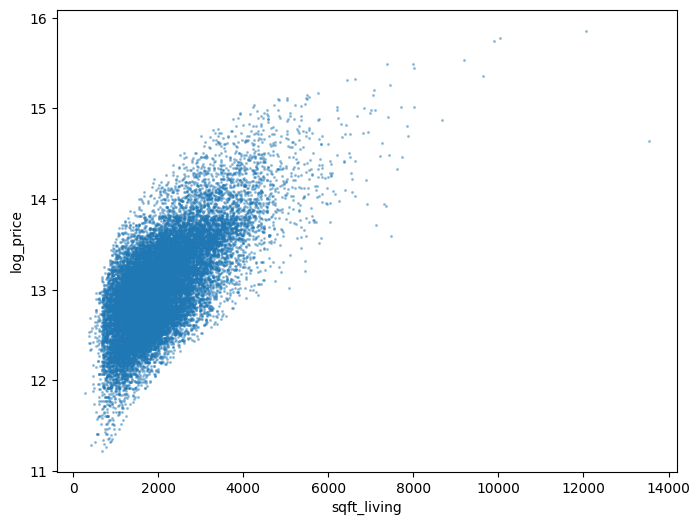

In [6]:
var_scatter(df)

## Starting Point -- Bivariate Linear Regression
Bivariate means "two variables", so in **Bivariate Linear Regression**, we have one independent variable and one dependent variable. For example, we may want to model the `log(price)` has a **linear** function of the `sqft_living`:

$$
\log(price_i) = \beta_0 + \beta_1 * sqft\_living_i + \epsilon_i
$$

In this equation,
- $i$ indexes an observation (e.g. a house sale)
- $\beta_0$ and $\beta_1$ are called coefficients (or more generally, parameters). Finding the coefficients that best fit the data will be the job of a linear regression algorithm.
- $\epsilon$ captures error as it is unlikely that the log price of a home is a linear function only square footage.

Notice, that we are making an implicit assumption on the relationship between $X$ and $y$. We are setting $f(\cdot)$ as a linear function of $X$. Hence the name, Linear Regression.

The linear regression algorithm, also know as Ordinary Least Squares (OLS), chooses the values of $\beta_0$ and $\beta_1$ that minimize the following equation:

$$
\frac{1}{n}\sum_{i=1}^{n} \epsilon_i^2 = \frac{1}{n}\sum_{i=1}^{n} (y_i -\hat{y})
$$

$$
\frac{1}{n}\sum_{i=1}^{n} \epsilon_i^2 = \frac{1}{n}\sum_{i=1}^{n} \left( \log(price_i) - \left(\beta_0 + \beta_1 * sqft\_living_i\right)\right)^2
$$
where  $\left(\beta_0 + \beta_1 * sqft\_living_i\right)$ would be the predicted value ($\hat{y}$) of $\log(price)$ given $sqft\_living$ and `n` is the sample size of our data (the number of sold houses)

This is an example of what is called a **loss function** of an estimated model, and the mean squared error (what you see above) is one of the most common loss functions. This loss function serves as a measure of fit where lower numbers indicate that the line fits the data better.

Below,  `sns.lmplot` automatically calculates the OLS estimates of $\beta_0$ and $\beta_1$ and uses those estimates to plot a line of best fit and the scatter plot of the variables in question.

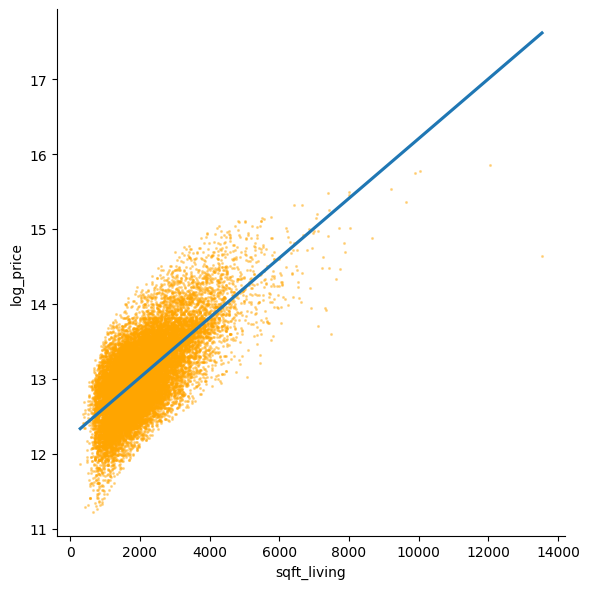

In [7]:
sns.lmplot(
    data=df, x="sqft_living", y="log_price", height=6,
    scatter_kws=dict(s=1.5, alpha=0.35, color='orange'),
    ci=False
)

## `scikit-learn`
To estimate anything more complicated that a basic bivariate regression, we will use `scikit-learn`. To learn it, let's replicate the plot provided by `sns.lmplot`. First, we complete the following steps to estimate the linear regression.

In [8]:
# Import the model
from sklearn import linear_model

In [10]:
# Step1: Initialize model
sqft_lr_model = linear_model.LinearRegression()

# Step2: Fit the model (this means estimate beta_0 and beta_1 using our data!)
sqft_lr_model.fit(X[["sqft_living"]], y)

LinearRegression()

In [11]:
# print the coefficients
beta_0 = sqft_lr_model.intercept_
beta_1 = sqft_lr_model.coef_[0]

print(f"Fitted model: log(price) = {beta_0:.4f} + {beta_1:.4f} sqft_living")

Fitted model: log(price) = 12.2185 + 0.0004 sqft_living


## Equation for a Line
As we can see above, estimate a bivariate regression model gives us an equation for a line. In the example above, our intercept is ~12.2185 and our slope is ~.0004.

## Interpretation
- $\beta_0$: The average log(price) of houses whit a size of zero square foot is 12.22
- $\beta_1$: On average, an increase of **1 unit** (1 square meter) in the size of houses is **associated** with an increase of 0.04 percent in the price (or **0.0004 log units**)

### Interpretability vs. Flexibility
While linear regression is quite simple and assumes that the relationship between two variables is linear (in this case the $\log(price)$ and $sqft\_living$), other more advanced statistical estimators and machine learning methods are much more flexible.

Linear regression, however, is one of, if not the most, interpretable regression model. That is, we can clearly see the relationship between variables by looking at the coefficients.

### Correlation is not Causation!
Try and avoid using language that suggests a causal relationship. That is, you **cannot** claim that a one squarefoot increase **causes** or **results in** a .00004 increase in the log of sale price. This type of statement requires stronger assumptions and consequently, a more sophisticated research design.




## Mutability
Note how we did not need to reassign `sqft_linear_model` when calling `.fit()`. This is because linear model objects are mutable and the `.fit()` method edits the underlying objects, so reassignment is not required.




## Plotting our Line
Now that we've talked about the equation, let's finish recreating the regression plot.

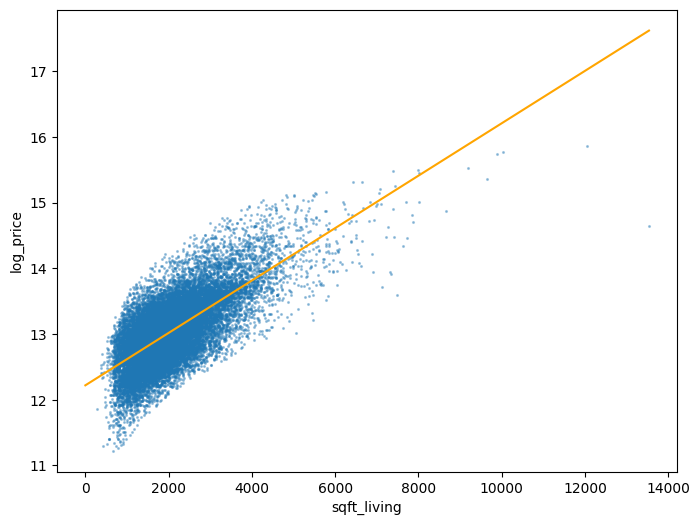

In [14]:
# Create scatter plot of `log_price` and `sqft_living`
ax = var_scatter(df)

# Create points linspace for line
x = np.linspace(0, df["sqft_living"].max(), 200)
yhat = beta_0 + beta_1*x
ax.plot(x, yhat, color='orange')

### Prediction
Above, we used the fitted coefficients of our linear model to generate `Yhat` -- the predicted values of `log(price)` given `sqft_living`. Alternatively, we can use the `.predict()` method to evaluate the model for any value of `sqft_living`.



In [15]:
# Predict the price of house with 5000 square feet of living space
logp_5000 = sqft_lr_model.predict([[5000]])[0]

print(f"The model predicts a 5,000 sq. foot home would have a log(price) of {logp_5000:.2f} dollars")

# Alternatively, we could say
print(f"The model predicts a 5,000 sq. foot home would cost ${np.exp(logp_5000):.2f} dollars")

The model predicts a 5,000 sq. foot home would have a log(price) of 14.21 dollars
The model predicts a 5,000 sq. foot home would cost $1486889.32 dollars


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## Multivariate Linear Regression
Clearly, the price of a home in King County, Washington is not determined soley by how big it is. Indeed, we may want to add another independent variable, such as the number of bathrooms a house has, into our regression equation. Now, our model is:
$$
\log(price_i) = \beta_0 + \beta_1 * sqft\_living_i +  \beta_2 * bathrooms_i + \epsilon_i
$$

### Linear Regression in Matrix Form
For brevity, we can rewrite the equation above for each observation in matrix notation:

$$
\underbrace{\begin{bmatrix} \log(\text{price}_1) \\ \log(\text{price}_2) \\ \vdots \\ \log(\text{price}_n)\end{bmatrix}}_y = \underbrace{\begin{bmatrix} 1 & \text{sqft_living}_1 & \text{bathrooms}_1 \\ 1 & \text{sqft_living}_2 & \text{bathrooms}_2 \\ \vdots & \vdots & \vdots \\ 1 & \text{sqft_living}_n & \text{bathrooms}_n \end{bmatrix}}_{X} \underbrace{\begin{bmatrix} \beta_0 \\ \beta_1 \\ \beta_2 \end{bmatrix}}_{\beta} + \begin{bmatrix} \epsilon_1 \\ \epsilon_2 \\ \vdots \\ \epsilon_n\end{bmatrix}
$$
That is, we can compactly express these euqations as $y = X\beta + \epsilon$.

If we want to add another independent variable such as the number of floors (called `floors`) we can still write $y = X\beta + \epsilon$, but now it is understood that we mean
$$
\underbrace{\begin{bmatrix} \log(\text{price}_1) \\ \log(\text{price}_2) \\ \vdots \\ \log(\text{price}_n)\end{bmatrix}}_y = \underbrace{\begin{bmatrix} 1 & \text{sqft_living}_1 & \text{bathrooms}_1 & \text{floors}_1 \\ 1 & \text{sqft_living}_2 & \text{bathrooms}_2 & \text{floors}_2\\ \vdots & \vdots & \vdots \\ 1 & \text{sqft_living}_n & \text{bathrooms}_n & \text{floors}_n\end{bmatrix}}_{X} \underbrace{\begin{bmatrix} \beta_0 \\ \beta_1 \\ \beta_2 \\ \beta_3\end{bmatrix}}_{\beta} + \epsilon
$$

Now the mean-squared error loss function can be expressed as
$$
\frac{1}{n} \sum_{i=1}^n (y_i - X_i \beta)^2 = \frac{1}{n} \| y - X \beta\|_2^2
$$
where
- $\| y - X \beta\|_2^2$ is squared l2-norm of the vector  $y - X \beta$.
- $X_i$ is a vector of independent variables (e.g. $[1 \text{ sqft_living}_2  \text{ bathrooms}_2  \text{ floors}_2]$)
- $y_i$ is the dependent variable of the $i$th observation (e.g $\log(\text{price$_2$})$)

## Running Multivariate Regression
Now, we will take all column variables in `X` as our independent variables to predict `log(price)`. Using `sklearn`, it is just as easy to fit a multivariate regression with 18 variables as it was to fit a Bivariate regression.

In [16]:
# We initialize and fit the model in the same way as before
multi_lr_model = linear_model.LinearRegression()
multi_lr_model.fit(X, y)

LinearRegression()

In [26]:
coefficients = multi_lr_model.coef_
feature_names = X.columns
dict(zip(feature_names, coefficients))

{'bedrooms': -0.010417359500147008,
 'bathrooms': 0.0702519913299664,
 'sqft_living': 9.38273959718666e-05,
 'sqft_lot': 4.69871942494252e-07,
 'floors': 0.06857845175388654,
 'waterfront': 0.3766143751669719,
 'view': 0.05658791942120984,
 'condition': 0.06778900476104137,
 'grade': 0.16040749681386707,
 'sqft_above': 4.0230317269953405e-05,
 'sqft_basement': 5.3597078518630456e-05,
 'yr_built': -0.0032287090175171745,
 'yr_renovated': 3.849769671442162e-05,
 'lat': 1.3537633806797063,
 'long': -0.05080060885870807,
 'sqft_living15': 0.0001049425525266946,
 'sqft_lot15': -2.728126661989698e-07}

## Evaluate Model Performance
The drawback to multivariate regression is that we cannot easily visualize 18 variables and their relationship simultaneously. What we can do just as easily, however, is evaluate the performance (also called fit) of the regression.

Below, we define `mse_bivariate` and `mse_multivariate` to be equal to the mean-squared error of the bivariate regression model and multivariate regression models resepctively. While it would be relatively easy to code such a calculation ourselves, we can import `sklearn.metrics`. Then, we feed the true dependent variable values (`y`) and the predicted values to its `mean_squared_error` function to get our measure of fit.

Here you can start to see the benefit of `.predict()` as we do not have to save all of the variables as coefficients to manually predict observations.

In [ ]:
from sklearn import metrics

In [28]:
mse_bivariate = metrics.mean_squared_error(y, sqft_lr_model.predict(X[["sqft_living"]]))
mse_multivariate = metrics.mean_squared_error(y, multi_lr_model.predict(X))

print(f"Our Bivariate model had a mean-squared error of {mse_bivariate:.4f}")
print(f"Our Multivariate model had a mean-squared error of {mse_multivariate:.4f}")

Our Bivariate model had a mean-squared error of 0.1433
Our Multivariate model had a mean-squared error of 0.0644


## Modeling Nonlinear Relationships with Linear Regression
It is unintuitive, but linear regression models can model our dependent variable as a non-linear function of our independent variables.

In linear regression, each prediction is generated by multiplying many independent variables by their own coefficients and then adding those products together. If we define our variables as functions of other variables, we can estimate coeffcients on nonlinear terms.

In the example below, we estimate the coefficients for the following non-linear equation:
$$
\log(price_i) = \beta_0 + \beta_1 * sqft\_living_i + \beta_2 * sqft\_living_i^2 + \epsilon_i
$$

To code this, we simply need to define a column `sqft_living_sq` that is the square of the `sqft_living` column.

In [31]:
# Define new variables
X2 = X[["sqft_living"]].copy()
X2["sqft_living_sq"] = X[["sqft_living"]] ** 2

# Initiae the model and fit the data
poly_lr_model = linear_model.LinearRegression()
poly_lr_model.fit(X2, y)

# Obtain prediction results
new_mse = metrics.mean_squared_error(y, poly_lr_model.predict(X2))
old_mse = metrics.mean_squared_error(y, sqft_lr_model.predict(X2[["sqft_living"]]))

print(f"MSE of non-linear model, with squared term: {new_mse}")
print(f"MSE of linear model: {old_mse}")

MSE of non-linear model, with squared term: 0.14243670259568972
MSE of linear model: 0.14326910852241476


### Assessment and Non-linear Plot
It seems that adding the squared term improve the mse by ~.0008. In fact, adding more terms to an already existing regression will always maintain or reduce your loss function.

Now we can plot our non-linear plot as we printed our linear one.

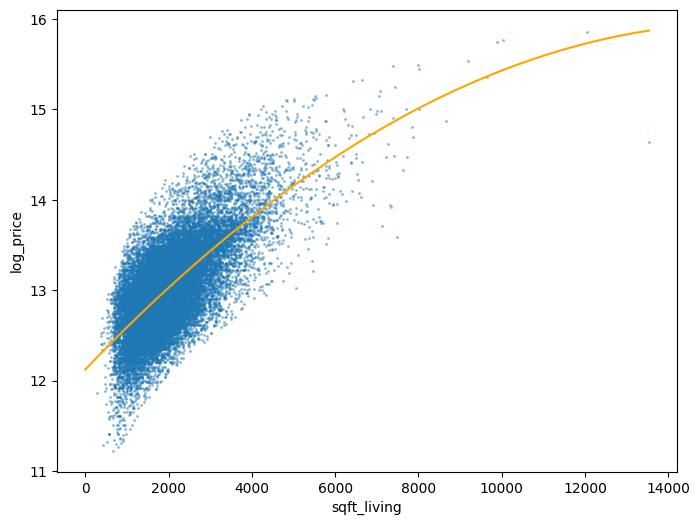

In [32]:
# Create scatter plot of `log_price` and `sqft_living`
ax = var_scatter(df)

# Create points linspace for line
x = np.linspace(0, df["sqft_living"].max(), 200)
x2 = pd.concat([pd.Series(x), pd.Series(x ** 2)], axis = 1)
x2.columns = ["sqft_living","sqft_living_sq"]
yhat = poly_lr_model.predict(x2)
ax.plot(x, yhat, color='orange')

In [33]:
poly_lr_model.coef_

array([ 4.82413345e-04, -1.51812015e-08])

### Interpretability Revisited
Note how this regression is hardered to determine because how much `log_price` changes with `sqft_living` (that is the slope of the line) is different at different levels of `sqft_living`.

### Choosing Your Independent Variables
Having many variables is not costless both from a statistical perspective and a data collection perspective.

Choosing which variables we should include in $X$ is a problem known as **variable selection**. In the machine learning world, this is also called **feature engineering**. Humans can use domain knowledge and theory to motivate the inclusion of certain independent variables.

## Lasso Regression
When domain knowledge is not enough or in a big data context, you can let the data select variables for you. **Lasso regression** is similar to linear regression in that it generates predictons using a linear function, i.e. $y = f(X) + \epsilon = X\beta + \epsilon$.

The difference is that Lasso's loss function has an extra term. Instead of choosing $\beta$ to minimize the mean-squared error, $\beta$ is chosen to **minimize** the following loss function
$$
 || y - X \beta||_2^2 + \underbrace{\alpha {|| \beta ||_1}}_{\text{new part}}.
$$

A few things to note:
- The first part, is essentially the same as the mean-squared error, except we do not divide by $n.$
- The second term is new and includes $||\beta||_1 = \sum_{l=1}^{k}|\beta_{k}|$ which is known as the $L_1$ norm of $\beta$.
- $\alpha$ is known as a regularization parameter -- more on this later.
- When $\alpha = 0$, Lasso is just the standard linear regression problem (OLS).
- As we increase $\alpha$, lasso sets the coefficients of the independent variables that provide the least information about $y$ to 0 first.
- Once $\alpha$ is high enough, optimal coefficients are all 0.

Since a Lasso Algorithm will choose a $\beta$ that minimizes the above loss function, the second term discourages it from choosing large coefficient values. The larger $\alpha$ is, the more "discouraged" lasso will be from choosing large values for $\beta_0$, $\beta_1$, etc.

This may seem a bit complcated, so let's look at an example using `linear_model.Lasso()` from `sklearn`. We will apply it to our example using all characteristics of a house.

### Quick Aside: Standardizing Your Data
Before estimating a lasso model, it is generally recommended to standardize your variables. Informally speaking, this ensures that your variables are roughly comparable with eachother and results in much better performance.

For now, we will not standardize variables. This will allow us to more easily compare our lasso model coefficients with linear regression for pedagogical purposes. We will introduce standardization later.

In [35]:
# Step1: Initialize lasso model
lasso_model = linear_model.Lasso(alpha = 1, max_iter =10000)

# Step2: Fit model
lasso_model.fit(X, y)

Lasso(alpha=1, max_iter=10000)

In [37]:
# Get lasso coefs
lasso_coefs = pd.Series(dict(zip(X.columns, lasso_model.coef_)))

# Get Linear Regression coefs
lr_coefs = pd.Series(dict(zip(X.columns, multi_lr_model.coef_)))

# Look at the two together
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
coefs

,lasso,linreg
bedrooms,-0.000000e+00,-1.041736e-02
bathrooms,0.000000e+00,7.025199e-02
sqft_living,3.027751e-04,9.382740e-05
sqft_lot,2.322538e-07,4.698719e-07
floors,0.000000e+00,6.857845e-02
waterfront,0.000000e+00,3.766144e-01
view,0.000000e+00,5.658792e-02
condition,0.000000e+00,6.778900e-02
grade,0.000000e+00,1.604075e-01
sqft_above,-0.000000e+00,4.023032e-05


### Observe the Differences
Note how the lasso coefficients tend to be smaller (except for the ones that were already very small) and that many of them are set exactly to 0. This is because of the $L_1$ penalization. Below, we print the mean-squared error for each model. Which one is bigger? Why does that make sense?





In [40]:
print(metrics.mean_squared_error(y, multi_lr_model.predict(X)))
print(metrics.mean_squared_error(y, lasso_model.predict(X)))

0.06439355015515341
0.1299513962570362


We never specified what alpha should be! Luckily, we can see below that the default value of $\alpha = 1$ was chosen.

In [41]:
print(lasso_model.alpha)

1


## How is this Variable Selection?
If we are just interested in prediction, we can use the coefficients it finds to predict models, just like linear regression as we did above.

If, however, we are interested in interpretability of the coefficients, it might make more sense to take all of the variables that have nonzero coeffcients in the lasso regression and run a normal linear regression with them.

We show the resulting coefficients next to the corresponding coefficients from the Lasso regression above. Do you expect these coefficients to be different or the same? Why?

In [44]:
# Find Non-zero variables
selected_vars = lasso_coefs[lasso_coefs != 0].index
selected_vars

Index(['sqft_living', 'sqft_lot', 'sqft_basement', 'yr_built', 'yr_renovated',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [46]:
# Initialize model
selected_lr_model = linear_model.LinearRegression()

# Fit the model on only the selected variables
selected_lr_model.fit(X[selected_vars], y)

selected_coefs = pd.Series(dict(zip(list(X[selected_vars]), selected_lr_model.coef_)))
selected_coefs = pd.DataFrame(dict(lasso=lasso_coefs[lasso_coefs != 0], linreg=selected_coefs))
selected_coefs

,lasso,linreg
sqft_living,3.027751e-04,3.199600e-04
sqft_lot,2.322538e-07,2.034527e-07
sqft_basement,2.162233e-05,-3.784033e-06
yr_built,-1.515928e-03,-3.024209e-03
yr_renovated,8.027335e-05,6.155187e-05
sqft_living15,1.916450e-04,2.008997e-04
sqft_lot15,-1.132635e-06,-1.126676e-06


If you want to understand the relationship between variables instead of simply predicting, you will want probably want to run a standard linear regression with the Lasso selected variables.

### Small and Large $\alpha$
Going back to considering all variables, let's observe how the estimated coefficients compare to the normal linear regression estimates when we choose $\alpha$ to be relatively small or large.

In [47]:
# Choose two alpha levels
small_alpha = 1e-2
big_alpha = 50

# Initialize both models -- this is where we specify regularization paramaeter alpha
small_alpha_model = linear_model.Lasso(alpha = small_alpha, max_iter=10000)
big_alpha_model = linear_model.Lasso(alpha = big_alpha)

# Fit both models using their respective alphas
small_alpha_model.fit(X, y)
big_alpha_model.fit(X, y)

# Get lasso coefs
small_alpha_coefs = pd.Series(dict(zip(list(X), small_alpha_model.coef_)))
big_alpha_coefs = pd.Series(dict(zip(list(X), big_alpha_model.coef_)))

# Get all coeffs into one DataFrame
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
coefs = pd.concat([coefs, small_alpha_coefs, big_alpha_coefs], axis = 1)
coefs.columns = ["lasso_alpha=1", "linear_regression", "lasso_alpha=.01", "lasso_alpha=10"]
coefs[["linear_regression", "lasso_alpha=.01",  "lasso_alpha=1", "lasso_alpha=10"]]

,linear_regression,lasso_alpha=.01,lasso_alpha=1,lasso_alpha=10
bedrooms,-1.041736e-02,-0.000000e+00,-0.000000e+00,0.000000e+00
bathrooms,7.025199e-02,3.383685e-02,0.000000e+00,0.000000e+00
sqft_living,9.382740e-05,1.559508e-04,3.027751e-04,3.065527e-04
sqft_lot,4.698719e-07,3.333255e-07,2.322538e-07,1.583511e-07
floors,6.857845e-02,4.587826e-02,0.000000e+00,0.000000e+00
waterfront,3.766144e-01,0.000000e+00,0.000000e+00,0.000000e+00
view,5.658792e-02,5.197960e-02,0.000000e+00,0.000000e+00
condition,6.778900e-02,2.770442e-02,0.000000e+00,0.000000e+00
grade,1.604075e-01,1.690761e-01,0.000000e+00,0.000000e+00
sqft_above,4.023032e-05,0.000000e+00,-0.000000e+00,0.000000e+00


### Choice of $\alpha$ Matters
Clearly, the choice of $\alpha$ affects which coefficients are set to 0 and the values of non-zero coefficients. At this point, you might be wondering how $\alpha$ should be chosen. Before answering that, we must understand why we want to select variables in the first place.

## In- and out-of Sample Fit
We learned earlier that including an additional variable in a regression will, all else equal, always result in better fit (lower loss). Why would we want to exclude variables?

Two types of fit/loss:
- **In-sample fit** refers to how well an estimated model fits the data that was used to estimate the model in the first place.
- **Out-of-Sample fit** refers to how well an estimator fits data that was not used for estimation.


All else equal, including more variables in our regression will always **maintain or improve** our **in-sample fit**.

No such guarantee exists for data our estimator has not seen. That is, adding another variable **can decrease** **out-of-sample fit**.

## Overfitting
Variable selection is one way to avoid an issue called **overfitting**.

**Overfitting** occurs when our model speicalizes its parameters (e.g. coefficients in linear regression) too much on the data it has seen only to perform worse on new, never-before-seen data.

It helps to imagine an extreme example:
- Imagine a model that just memorizes half of the house pricing data we give it.
- When you ask for a prediction on one house in the half it has seen, it gives you the exact value for `log(price)` value back.
- When you ask the same model for a prediction on a house it has not seen the data for, it just guesses a random positive number as the `price`.

The aforementioned model overfits a lot:
- This model attains perfect **in-sample** fit and 0 loss (in terms of MSE).
- This model's **out-of-sample** fit is basically as bad as it can be -- nothing is learned about the underlying relationship between variables.
- An in-sample loss (MSE) that is lower than the out-of-sample loss (MSE) is evidence of overfitting.

Clearly, the model we proposed is not really learning. Just like a math teacher expects you to learn algebra so you can rearrange equations you have never seen before, we want our machine learning algorithms and other statistical estimators to learn a pattern or a relationship between variables, so they can accurately predict $y$ when we don't know what it will be.

Below, we can split our data into two, a **training dataset** and a **testing dataset**. Then, we estimate a linear regression model and a lasso model on the training dataset and evaluate their **in-sample**  (training) and **out-of-sample** (testing) performance.

For instruction purposes, we will estimate our model only on the first fifty row (sold houses) in our dataset.

In [51]:
# Divide the first sample up
n_test = 50
X_train = X.iloc[:n_test, :]
X_test = X.iloc[n_test:, :]
y_train = y.iloc[:n_test]
y_test = y.iloc[n_test:]

In [52]:
# Estimate Lasso and Linear Regression
linear_model_20k = linear_model.LinearRegression().fit(X_train, y_train)
lasso_model_20k = linear_model.Lasso(alpha = (np.exp(-3)), max_iter = 100000).fit(X_train, y_train)
selected_vars = lasso_coefs[lasso_coefs != 0].index

# Initialize model
selected_lr_model = linear_model.LinearRegression()

# Fit the model on only the selected variables
selected_lr_model.fit(X[selected_vars], y)
print(f"In-sample MSE for linear regression is {metrics.mean_squared_error(y_train, linear_model_20k.predict(X_train))}")
print(f"In-sample MSE for lasso regression is {metrics.mean_squared_error(y_train, lasso_model_20k.predict(X_train))}")
print(f"Out-of-sample MSE for linear regression is {metrics.mean_squared_error(y_test, linear_model_20k.predict(X_test))}")
print(f"Out-of-sample MSE for lasso regression is {metrics.mean_squared_error(y_test, lasso_model_20k.predict(X_test))}")

In-sample MSE for linear regression is 0.0614592745167231
In-sample MSE for lasso regression is 0.10747681350030129
Out-of-sample MSE for linear regression is 0.06545730967205413
Out-of-sample MSE for lasso regression is 0.11596797862707933


In this example,
- Linear regression has significantly higher out-of-sample errors than in-sample errors
- The lasso model has a better out of sample performance despite having a worse in-sample fit

Both of these suggests that the standard linear model overfits when we use a sample size of 50.

If, however, we use more of the data to train the model (change `n_test = 50` to `n_test = 2000`), we start to see that neither model performs significantly worse out-of-sample than it does in-sample.

## Regularization
Model **regularization** is a class of techniques that we can use to reduce overfitting. Regularization aims to limit a model's ability to overfit to idiosyncratic aspects of the data it is fit (or trained) on. One way of doing this is by penalizing extreme parameter values.

For example, Lasso penalizes coefficient values ($\beta_0, \beta_1$, etc.) with large magnitudes by including the $\alpha ||\beta||_1$ term. The higher our regularization parameter ($\alpha$), the more the model is encouranged to set those coefficients closer to 0. In order to combat this penalization, high coeffcient values have to reflect import underlying trends.  We can see this in the plot below.

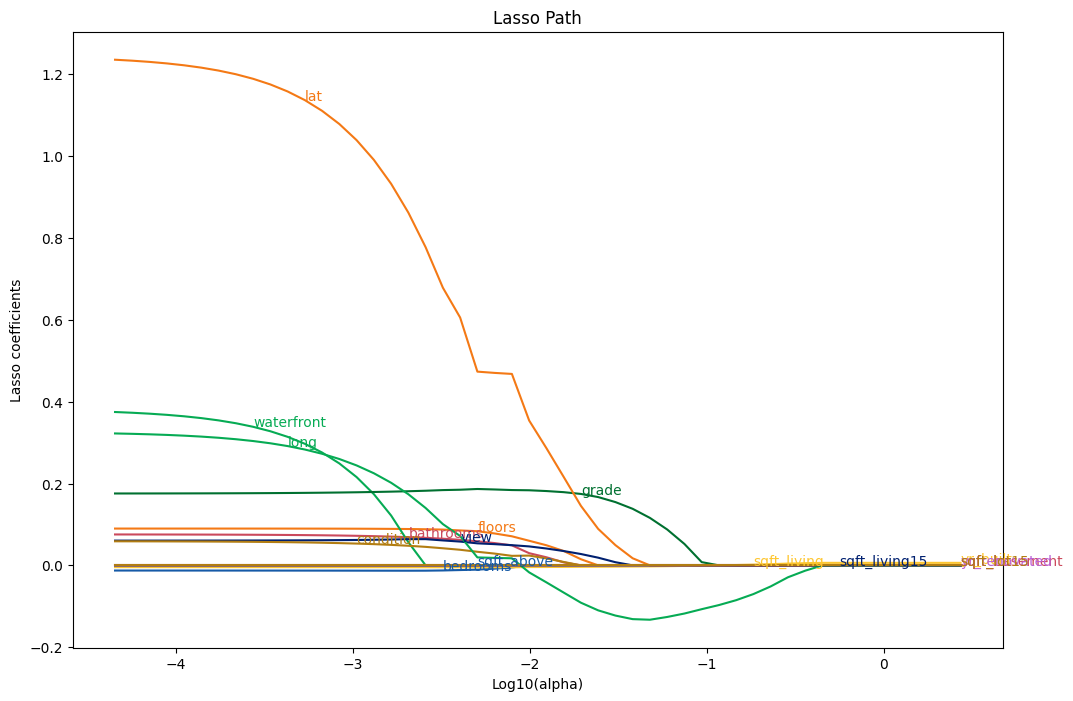

In [53]:
from itertools import cycle
colors = ['#165aa7', '#cb495c', '#fec630', '#bb60d5', '#f47915', '#06ab54', '#002070', '#b27d12', '#007030']
alphas = np.exp(np.linspace(-10, 1, 50))
alphas, coefs_lasso, _ = linear_model.lasso_path(X, y, alphas=alphas, max_iter=1000000)

# plotting
fig, ax = plt.subplots(figsize=(12, 8))
color_cycle = cycle(colors)
log_alphas = np.log10(alphas)
for coef_l, c, name in zip(coefs_lasso, color_cycle, list(X)):
   ax.plot(log_alphas, coef_l, c=c)
   ax.set_xlabel('Log10(alpha)')
   ax.set_ylabel('Lasso coefficients')
   ax.set_title('Lasso Path')
   ax.axis('tight')
   maxabs = np.max(np.abs(coef_l))
   i = [idx for idx in range(len(coef_l)) if abs(coef_l[idx]) >= (0.9*maxabs)][0]
   xnote = log_alphas[i]
   ynote = coef_l[i]
   ax.annotate(name, (xnote, ynote), color=c)

### Examining Lasso Paths
Each line above represents a variable's coefficient and how it varies as we change $\alpha$. As you can see, all coefficients tend to 0 as we increase $\alpha$.  

Some of the paths, are a bit more abnormal. Specifically, we can see that `latitude` and `longitidude` have strange paths and very small variances.

## Standardization

Standardization improves performance of the Lasso estimator when variables have drastically different scales or variances. For example, to standardize `sqft_living`,  are three steps
1. Calculate the mean of `sqft_living`
2. Calculate the variance of `sqft_living`
3. Transform each element of `sqft_living` by subtracting the mean and dividing by the square root of the variance (standard deviation).

In [54]:
X.var()

bedrooms         8.650150e-01
bathrooms        5.931513e-01
sqft_living      8.435337e+05
sqft_lot         1.715659e+09
floors           2.915880e-01
waterfront       7.485226e-03
view             5.872426e-01
condition        4.234665e-01
grade            1.381703e+00
sqft_above       6.857347e+05
sqft_basement    1.958727e+05
yr_built         8.627973e+02
yr_renovated     1.613462e+05
lat              1.919990e-02
long             1.983262e-02
sqft_living15    4.697612e+05
sqft_lot15       7.455182e+08
dtype: float64

Let's see what happens when we standardize our variables before running lasso. We demonstrate how to use `preprocessing.StandardScaler()` to standardize our data. From now on, we will work with the standardized data when running lasso.

In [56]:
from sklearn import preprocessing

In [57]:
# This teaches our scaler how to standardize the data from X
scaler = preprocessing.StandardScaler().fit(X)

# This applies the standardization to X
X_scaled = scaler.transform(X)

In [58]:
# We can see variances and means of columns are roughly 1 an 0
print(X_scaled.var(axis = 0))
print(X_scaled.mean(axis = 0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 2.36705117e-16 -1.78843866e-16  2.41965231e-16  1.05202274e-17
 -3.15606823e-17 -5.26011371e-18 -1.05202274e-17 -2.57745572e-16
  2.52485458e-16  1.10462388e-16  6.83814783e-17  1.91468139e-15
  1.31502843e-18 -3.43228995e-14 -3.66761429e-14  8.15317626e-17
 -2.89306254e-17]


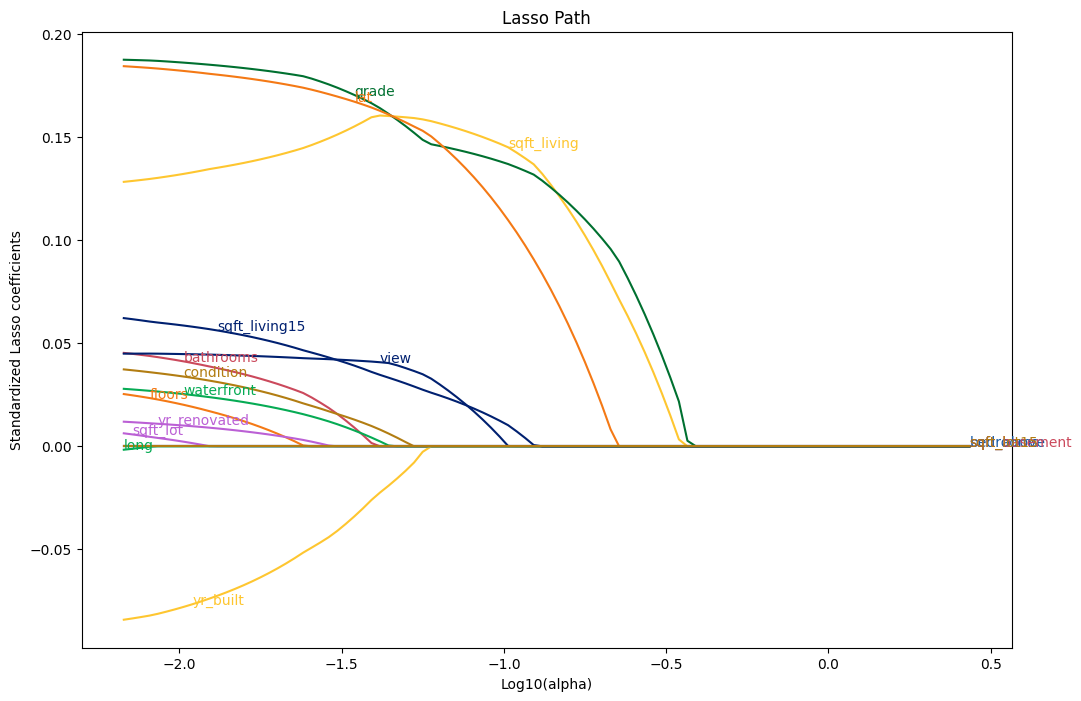

In [59]:
from itertools import cycle
colors = ['#165aa7', '#cb495c', '#fec630', '#bb60d5', '#f47915', '#06ab54', '#002070', '#b27d12', '#007030']
alphas = np.exp(np.linspace(-5, 1, 100))
alphas, coefs_lasso, _ = linear_model.lasso_path(X_scaled, y, alphas=alphas, max_iter=1000000)

# plotting
fig, ax = plt.subplots(figsize=(12, 8))
color_cycle = cycle(colors)
log_alphas = np.log10(alphas)
for coef_l, c, name in zip(coefs_lasso, color_cycle, list(X)):
   ax.plot(log_alphas, coef_l, c=c)
   ax.set_xlabel('Log10(alpha)')
   ax.set_ylabel('Standardized Lasso coefficients')
   ax.set_title('Lasso Path')
   ax.axis('tight')
   maxabs = np.max(np.abs(coef_l))
   i = [idx for idx in range(len(coef_l)) if abs(coef_l[idx]) >= (0.9*maxabs)][0]
   xnote = log_alphas[i]
   ynote = coef_l[i]
   ax.annotate(name, (xnote, ynote), color=c)

## Choosing $\alpha$ with a Holdout
Each value of $\alpha$ above gives us a regression model, but how do we choose among all of these models? One sensible approach is to choose the model (e.g. $\alpha$ for lasso) that has the best out-of-sample fit. We can do this by leaving out a portion of the data. Let's look at a plot that shows us the relationship between the mean squared error of a model and its $\alpha$ value.

In [60]:
# Function gets a dictionary for training and testing error
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )

In [61]:
# Select the train and test sample
n_test = 25
X_train_scale = X_scaled[:n_test, :]
X_test_scale = X_scaled[n_test:, :]
y_train = y.iloc[:n_test]
y_test = y.iloc[n_test:]

In [63]:
# Obtain the MSE for different alphas
alphas = np.exp(np.linspace(-5, 1, 100))

mse = pd.DataFrame([fit_and_report_mses(linear_model.Lasso(alpha=alpha, max_iter=50000),
                           X_train_scale, X_test_scale, y_train, y_test)
                    for alpha in alphas])
mse["log_alpha"] = np.log10(alphas)

Text(-1.381846078783074, 0.058291680496478634, 'train')

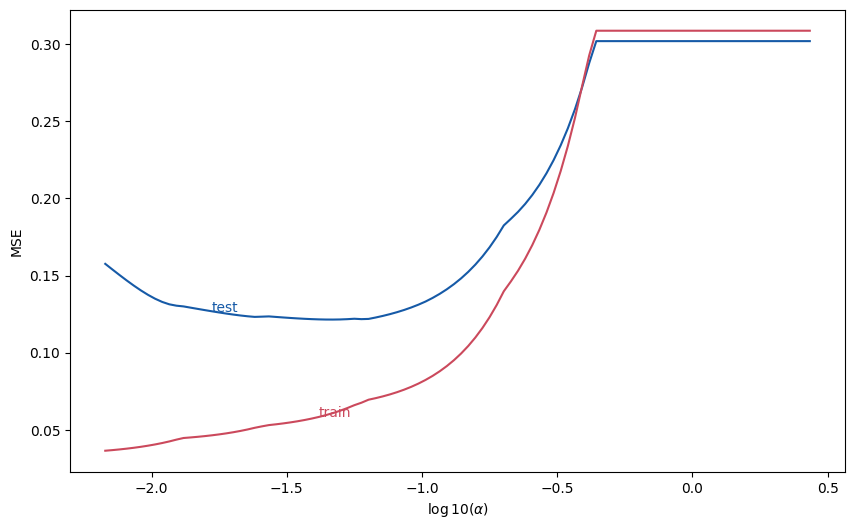

In [66]:
# Plot MSEs
fig, ax = plt.subplots(figsize=(10,6))
mse.plot(x="log_alpha", y="mse_test", c=colors[0], ax=ax)
mse.plot(x="log_alpha", y="mse_train", c=colors[1], ax=ax)
ax.set_xlabel(r"$\log10(\alpha)$")
ax.set_ylabel("MSE")
ax.get_legend().remove()
ax.annotate("test",(mse.log_alpha[15], mse.mse_test[15]),color=colors[0])
ax.annotate("train",(mse.log_alpha[30], mse.mse_train[30]),color=colors[1])

It looks like the minimum testing error might be around when $\log(\alpha)$ is around $-1.25$. Using a bit of code, we can find the minimum test error was attained at -1.329.



In [72]:
print(f"best performing model: log10(alpha) = {mse.loc[mse['mse_test'].argmin(), 'log_alpha']}")

best performing model: log10(alpha) = -1.3292043234008617


In this example, we used far to few observations  to actually train our model in order to illustrate certain behavioirs. In reality, you probably want to use more observations in your training sample than your testing sample. Instead of manually splitting you data, you can use `model_selection.train_test_split()` from `sklearn` as we do below

In [73]:
from sklearn import model_selection
Xtr, Xte, ytr, yte = model_selection.train_test_split(X, y, test_size=0.25)

### Not Just Lasso
This approach is common for many types of statistical learning algorithms, not just lasso.

## Cross-Validation
Cross-validation -- also known as $k$-fold cross validation -- is a more sophisticated method of evaluating a model's out-of-sample performance.

1. First break up your data into k subsets (or folds) of similar sizes.
2. Take one of those folds and do the following two steps
     - Fit the model on all data that **is not** in the fold (that is, the data in the remianing $k-1$ folds) for various levels of your regularization parameter.
     - Evaluate the performance of each model on the fold that was left out of training -- this will be used to evaluate out-of-sample-performance.
4. Repeat Step 2 for each fold.
5. Choose the value of $\alpha$ that had the best average out-of-sample performance across all $k$ folds.



In [76]:
from sklearn.model_selection import cross_val_score

In [77]:
mse["cv"] = [
    -np.mean(cross_val_score(
        linear_model.Lasso(alpha=alpha, max_iter=50000),
        X_train_scale, y_train, cv=5, scoring='neg_mean_squared_error')
    )
    for alpha in alphas
    ]

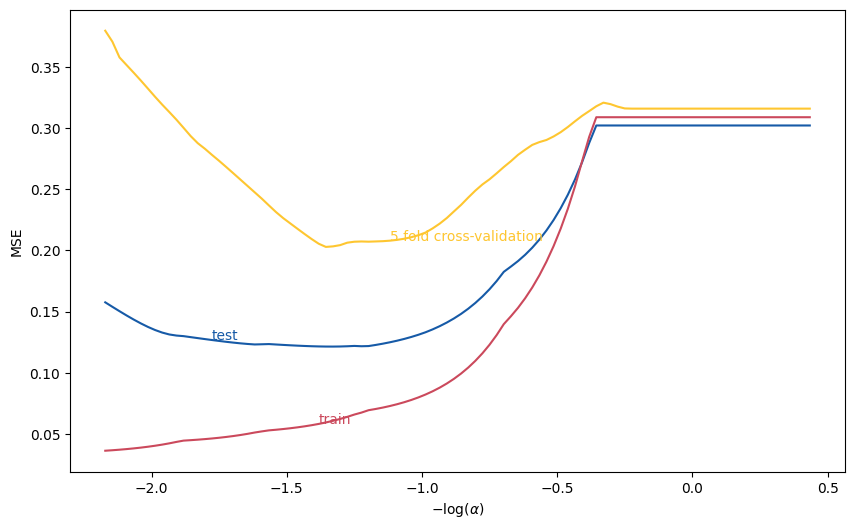

In [78]:
mse.plot(x="log_alpha", y="cv", c=colors[2], ax=ax)
ax.annotate("5 fold cross-validation", (mse.log_alpha[40], mse.cv[40]), color=colors[2])
ax.get_legend().remove()
ax.set_xlabel(r"$-\log(\alpha)$")
ax.set_ylabel("MSE")
fig

In this circumstance, we can once again use a bit of code to find the best value of $log(\alpha)$. In this circumstance, it is very similar to when we just used the test error.

In [80]:
print(f"best performing model: log10(alpha) = {mse.loc[mse['cv'].argmin(), 'log_alpha']}")

best performing model: log10(alpha) = -1.3555252010919678


### Scaled vs Unscaled
Finally, we will just briefly compare the scaled lasso performance with the unscaled one.

In [83]:
# Recreate training and test sample with more observations
n_test = 100
X_train_scale = X_scaled[:n_test, :]
X_test_scale = X_scaled[n_test:, :]

X_train = X.loc[:n_test-1, :]
X_test = X.loc[n_test:, :]

y_train = y.iloc[:n_test]
y_test = y.iloc[n_test:]

In [84]:
# Calculate MSEs for each model
alphas = np.exp(np.linspace(-8, 10, 100))
mse_scale = pd.DataFrame([fit_and_report_mses(linear_model.Lasso(alpha=alpha, max_iter=500000),
                           X_train_scale, X_test_scale, y_train, y_test)
                    for alpha in alphas])
mse = pd.DataFrame([fit_and_report_mses(linear_model.Lasso(alpha=alpha, max_iter=500000),
                           X_train, X_test, y_train, y_test)
                    for alpha in alphas])

mse_scale["log_alpha"] = np.log10(alphas)
mse["log_alpha"] = np.log10(alphas)

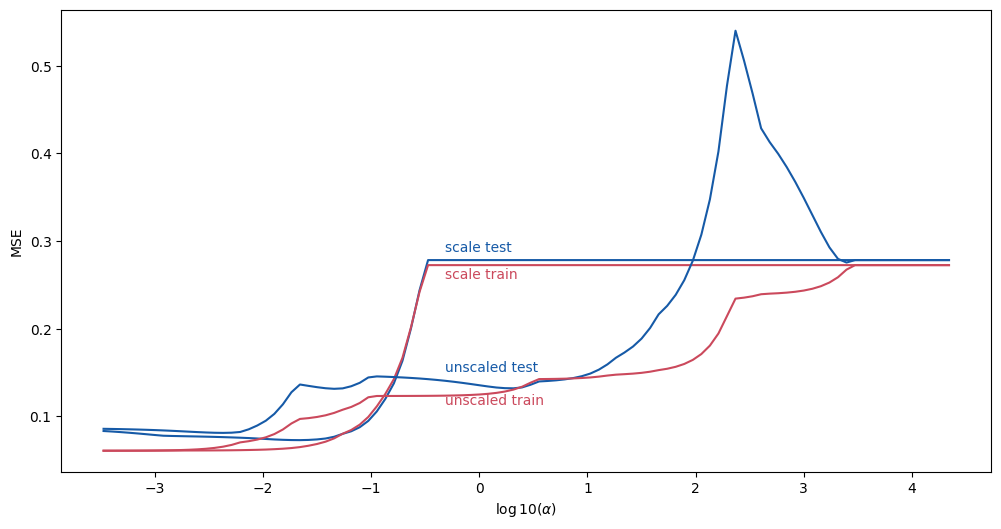

In [93]:
# Plot MSEs
fig, ax = plt.subplots(figsize=(12,6))
mse_scale.plot(x="log_alpha", y="mse_test", c=colors[0], ax=ax)
mse_scale.plot(x="log_alpha", y="mse_train", c=colors[1], ax=ax)

mse.plot(x="log_alpha", y="mse_test", c=colors[0], ax=ax)
mse.plot(x="log_alpha", y="mse_train", c=colors[1], ax=ax)

ax.set_xlabel(r"$\log10(\alpha)$")
ax.set_ylabel("MSE")
ax.get_legend().remove()
ax.annotate("scale test",(mse_scale.log_alpha[40], mse_scale.mse_test[40] + .01), color=colors[0])
ax.annotate("scale train",(mse_scale.log_alpha[40], mse_scale.mse_train[40] -.015), color=colors[1])
ax.annotate("unscaled test",(mse.log_alpha[40], mse.mse_test[40] + .01),color=colors[0])
ax.annotate("unscaled train",(mse.log_alpha[40], mse.mse_train[40] -.01),color=colors[1])

plt.show()

Can you explain why these plots look the way they do? Why is scaling better despite the fact that MSE of the scaled lasso grows more quickly than that of the unscaled one. What section of this graph should we pay attention to?

## Regression Trees & Random Forest,
The final regression techniques we will learn are Regression Trees & Random Forest algorithms. As the names suggest, a Random Forest is built of many regression trees, so it makes sense to first lean what a regression tree is.

## Regression Trees
Regression trees partition (or break up) data into smaller subsets and use the average of *in-sample* $y$ values in those subsets to predict all other points that also lie in the subset. Let's see a quick example.

$$\text{Sale Price} = \left\{\begin{array}{cc}
\$722,381.03 & \text{if sqft_living} > 2000 \\
\$385,982.03 & \text{if sqft_living} \leq 2000
\end{array} \right. $$

The simplest tree actually resembles a piece-wise function! If we were to use this tree to predict the sale price of a home, we would simply check whether `sqft_living` is above or below 2000. If it is above, the tree predicts $\$722,381.03$ otherwise it is $\$385,982.03$. We can draw this as a tree on the board.

We can also add another variable for our tree to consider.
$$\text{Sale Price} = \left\{\begin{array}{cc}
\$722,381.03 & \text{if sqft_living} > 2000 \\
\$376,221.83 & \text{if sqft_living} \leq 2000 \text{ & } \text{# bathrooms} \leq 2 \\
\$414,063.74 & \text{if sqft_living} \leq 2000 \text{ & } \text{# bathrooms} > 2
\end{array} \right. $$

We can draw this tree by adding another split to the tree we have already drawn! Again, we use the real averages in the dataset to generate these numbers.

In [94]:
# First Tree Means
print(df["price"][df["sqft_living"] > 2000].mean())
print(df["price"][df["sqft_living"] <= 2000].mean())

# Second Tree Means
print(df["price"][((df["sqft_living"] <= 2000) * (df["bathrooms"] <= 2))].mean())
print(df["price"][((df["sqft_living"] <= 2000) * (df["bathrooms"] > 2))].mean())

722381.0268659731
385982.79209357925
376221.82614198595
414063.7437934459


## Growing a Regression Tree
While these models are trees, the split points (sqft_living = 2000 & # bathrooms = 2) were arbitrarily determined by me, not the data.

Growing a tree is a process that determines splits variables (e.g. `sqft_living` and `bathrooms`)and the split values (e.g. 2000 and 2).
- First, the tree finds the split variable-value pair that results in the best measure of fit (e.g. sqft_living, 2000) when a simple mean is fit on points lying on either side of that split.
- The tree is solving the following minimization problem where $j$ indexes the variable we're splitting and $s$ is the value we're splitting on.

$$
\min_{j,s} \left[ \min_{c_1} \sum_{i: x_{i,j} \leq s, x_i \in R}
    (y_i - c_1)^2 + \min_{c_2} \sum_{i: x_{i,j} > s, x_i \in R}
    (y_i - c_2)^2 \right]
$$

notice this is simply a squared loss where $c_1$ or $c_2$ are predictions for $y_i$ depending on which side of the split a point is on.
- Then, the tree splits the data into two using that optimal split variable-value pair.
- This process is repeated again on the resulting two regions until some stopping condition is met.


## Regresison Tree code
Now that we have a better understanding of regression trees, let's build one using `scikitlearn`. Instead of using real data, we are going to create fake data (also known as simulation), so we can compare regression tree with the true underlying function. First, we generate the fake data as function of two variables. Specifically, our function is:
$$
y = \frac{1}{3} \sin(5x_1) + \sqrt{x_2} e^{-\left((x_2 - .5) ^ 2\right)} +\epsilon
$$
where $\epsilon$ makes the outcomes slightly random around this surface.

In [95]:
# Simulate some data and plot it
n = 1000
Xsim = np.random.rand(n,2)
def Ey_x(x):
    return 1/3*(np.sin(5*x[0])) + np.sqrt(x[1])*np.exp(-(x[1]-0.5)**2)

ysim = np.apply_along_axis(Ey_x, 1, Xsim) + np.random.randn(n)*0.1


Below, we plot the surface of our function and the points that were generated from it with some randomness.

In [96]:
# Do not worry about knowing all of this code.
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()

def surface_scatter_plot(X,y,f, xlo=0., xhi=1., ngrid=50,
                         width=860, height=700, f0=Ey_x, show_f0=False):
    scatter = go.Scatter3d(x=X[:,0],y=X[:,1],z=y,
                           mode='markers',
                           marker=dict(size=2, opacity=0.3)
    )
    xgrid = np.linspace(xlo,xhi,ngrid)
    ey = np.zeros((len(xgrid),len(xgrid)))
    ey0 = np.zeros((len(xgrid),len(xgrid)))
    colorscale = [[0, colors[0]], [1, colors[2]]]
    for i in range(len(xgrid)):
        for j in range(len(xgrid)):
            ey[j,i] = f([xgrid[i],xgrid[j]])
            ey0[j,i]= f0([xgrid[i],xgrid[j]])
    surface = go.Surface(x=xgrid, y=xgrid, z=ey, colorscale=colorscale, opacity=1.0)
    if (show_f0):
        surface0 = go.Surface(x=xgrid, y=xgrid, z=ey0, opacity=0.8, colorscale=colorscale)
        layers = [scatter, surface, surface0]
    else:
        layers = [scatter, surface]
    fig = go.FigureWidget(
        data=layers,
        layout = go.Layout(
            autosize=True,
            scene=dict(
                xaxis_title='X1',
                yaxis_title='X2',
                zaxis_title='Y'
            ),
            width=width,
            height=height,
        )
    )
    return fig

Output hidden; open in https://colab.research.google.com to view.

In [97]:
fig = surface_scatter_plot(Xsim, ysim, Ey_x)
iplot(fig)

Now that we know how our data is generated, we can grow a regression tree on this fake data and see how well it can approximate the underlying function. Before doing so, note how none of the points lie on this plane. This is because of the $\epsilon$ term. This will be important when we discuss overfitting in a moment.

Below, you will see that we set the `max_depth` to 3. This means that the tree cannot split three times consecutively. Setting this value to a low number helps regularize the tree and prevent it from overfitting.

In [ ]:
# Import the tree submodule
from sklearn import tree

# Initialize our tree so its max depth is 3
fitted_tree_3 = tree.DecisionTreeRegressor(max_depth=3)

# Fit tree on simulated data
fitted_tree_3.fit(Xsim,ysim)

# Plot Regresion Tree Surface
fig_3 =surface_scatter_plot(
    Xsim, ysim, lambda x: fitted_tree_3.predict([x]), show_f0=False
)
iplot(fig_3)

### Compare Plots
Notice how our regression tree surface plot which shows what our regression tree predicts for a given $X1$ and $X2$ is a "blocky" approximation of the true underlying surface. This is because we are estimating a smooth function with a what is essentially a stepwise function. If set `show_f0` equal to `True`, we can overlay the two surfaces and see they line up relatively well.  Below, we increase `max_depth` and show the same plot.  

In [ ]:
# Import the tree submodule
from sklearn import tree

# Initialize our tree so its max depth is 10
fitted_tree_10 = tree.DecisionTreeRegressor(max_depth=10)

# Fit tree on simulated data
fitted_tree_10.fit(Xsim,ysim)

# Plot Regresion Tree Surface
fig_10 =surface_scatter_plot(
    Xsim, ysim, lambda x: fitted_tree_10.predict([x]), show_f0=False
)
iplot(fig_10)

### Another Comparison
This plot is still blocky  but now the predictions our tree makes change much more abruptly with changes in $X1$ and $X2$. This manifests as steep slopes on the surface.

At this point, the tree resembles the original surface much less. This is because by allowing our tree to grow very deep, we're allowing it to fit to idiosyncratic aspects of the data (that is, it starts fitting to $\epsilon$). You can see  that the surface of the tree is being pulled towards data points more compared to the original.

Below, we generate more data and then observe in-sample and out-of-sample MSE of both the depth 3 and the depth 10 model. Which one will have better in-sample performance? How about out of sample?

In [ ]:
Xtest = np.random.rand(n,2)
ytest = np.apply_along_axis(Ey_x, 1, Xtest) + np.random.randn(n)*0.1

print(f"Tree of Depth 3 has in-sample MSE of {metrics.mean_squared_error(ysim, fitted_tree_3.predict(Xsim))}")
print(f"Tree of Depth 10 has in-sample MSE of {metrics.mean_squared_error(ysim, fitted_tree_10.predict(Xsim))}")
print(f"Tree of Depth 3 has out-of-sample MSE of {metrics.mean_squared_error(ytest, fitted_tree_3.predict(Xtest))}")
print(f"Tree of Depth 10 has out-of-sample MSE of {metrics.mean_squared_error(ytest, fitted_tree_10.predict(Xtest))}")

Tree of Depth 3 has in-sample MSE of 0.02008545555362475
Tree of Depth 10 has in-sample MSE of 0.002885979117755599
Tree of Depth 3 has out-of-sample MSE of 0.02323621855190286
Tree of Depth 10 has out-of-sample MSE of 0.019160571487031108


### Visualizing Trees
We can visualize the trees so they resemble what we have drawn on the board! We can see information about each node and the splits that were made.

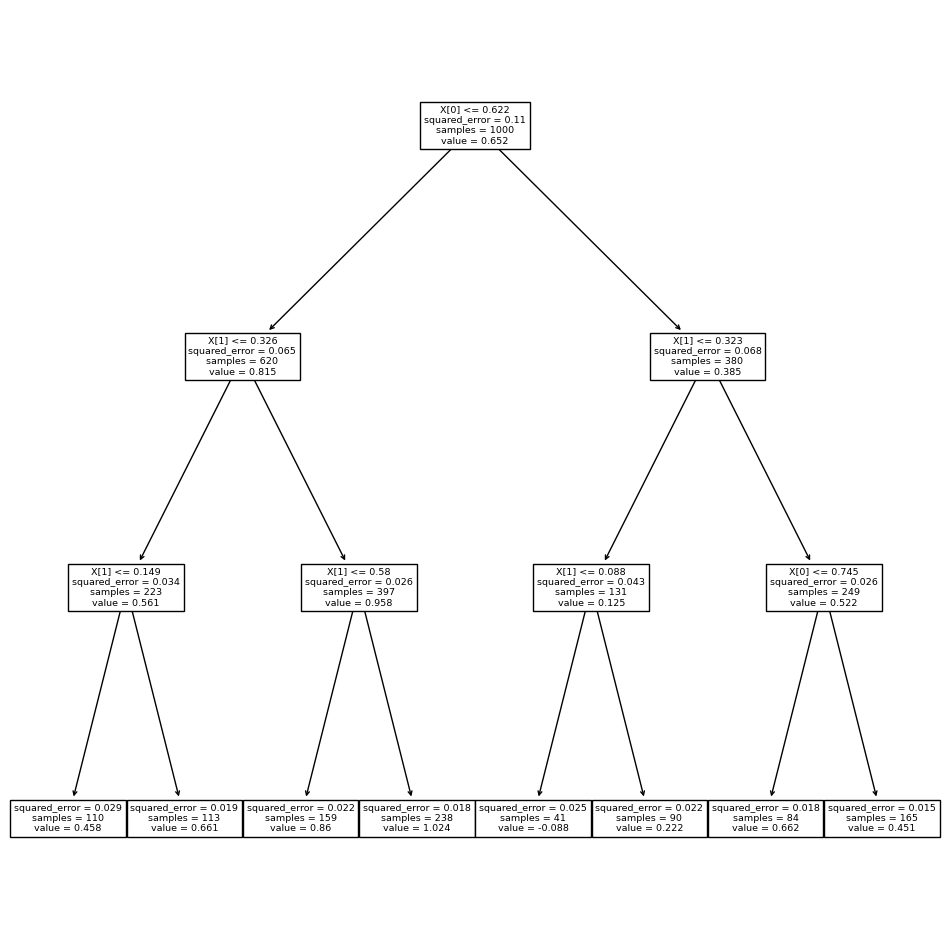

In [ ]:

from IPython.display import display
plt.figure(figsize=(12,12))
tree.plot_tree(fitted_tree_3);

### Pruning
We will not discuss the details, but a common regularization procedure called pruning entails growing the tree as deep as possible (no max depth argument) and then "pruning" the terminal splits that reduced MSE by the least. Pruning is repeated until were are only left with the first node and all of the data is fit together. This yields a sequence of trees that we can select from.

### Choosing a Model
Whether you're selecting tree from many model where you limited the `max_depth` or you're selecting from one of your pruned models, you can use the hold out and cross validation to select the best.  You will likely do this in your assignment.

### Categorical Variables
Regression trees can also use unordered categorical variables (e.g. college major, blood type, genre of music, etc.) as independen variables. Instead of trying to find a split variable-value, they will split based on whether a given observation is a class or not (e.g. economics major or not, AB positive or not, jazz or not, etc.).

`sklearn` does not deal with categorical variables as easily as we might like. It was to treat everything as a numerical variable using cutoff values. Instead of feeding it one column of categorical variables (e.g. `majors`), we can do what is known as `one hot encoding` which simply means we create a "dummy variables" for each class.

Below, we demonstrate a toy example with only categorical variables, but you can use one-hot encoded variables with numerical variables in the same tree.

In [ ]:
# Number of observations
n_cat = 800

# Deterministic college majors
majors =  200*["economics", "computer science", "history", "math"]

Xsim_cat = pd.get_dummies(pd.Series(majors))

# note how each major has been turned into its own column
Xsim_cat

,computer science,economics,history,math
0,0,1,0,0
1,1,0,0,0
2,0,0,1,0
3,0,0,0,1
4,0,1,0,0
...,...,...,...,...
795,0,0,0,1
796,0,1,0,0
797,1,0,0,0
798,0,0,1,0


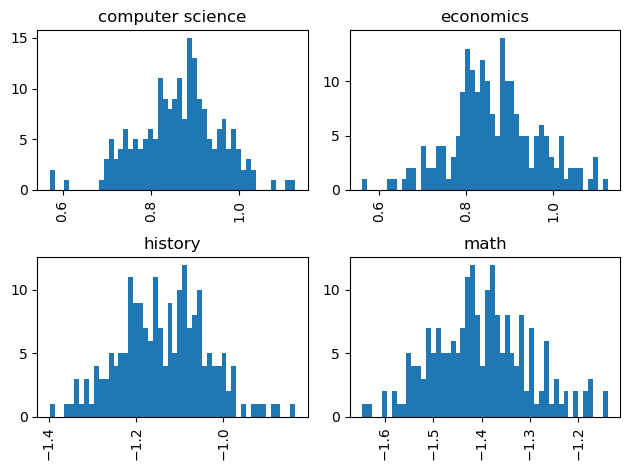

In [ ]:
# Generate y
ysim_cat = -1.4 * np.array(["m" in x for x in majors])+ 3.4 * np.array(["e" in x for x in majors]) -1.14 * np.array(["s" in x for x in majors])
ysim_cat = ysim_cat + np.random.randn(n_cat)*.1


histogram_df = pd.DataFrame(list(zip(ysim_cat,  majors)))
histogram_df.columns = ["y", "major"]
hist_plot = histogram_df.hist(column = "y", by = "major", bins = 50, layout = (2,2))
plt.tight_layout()


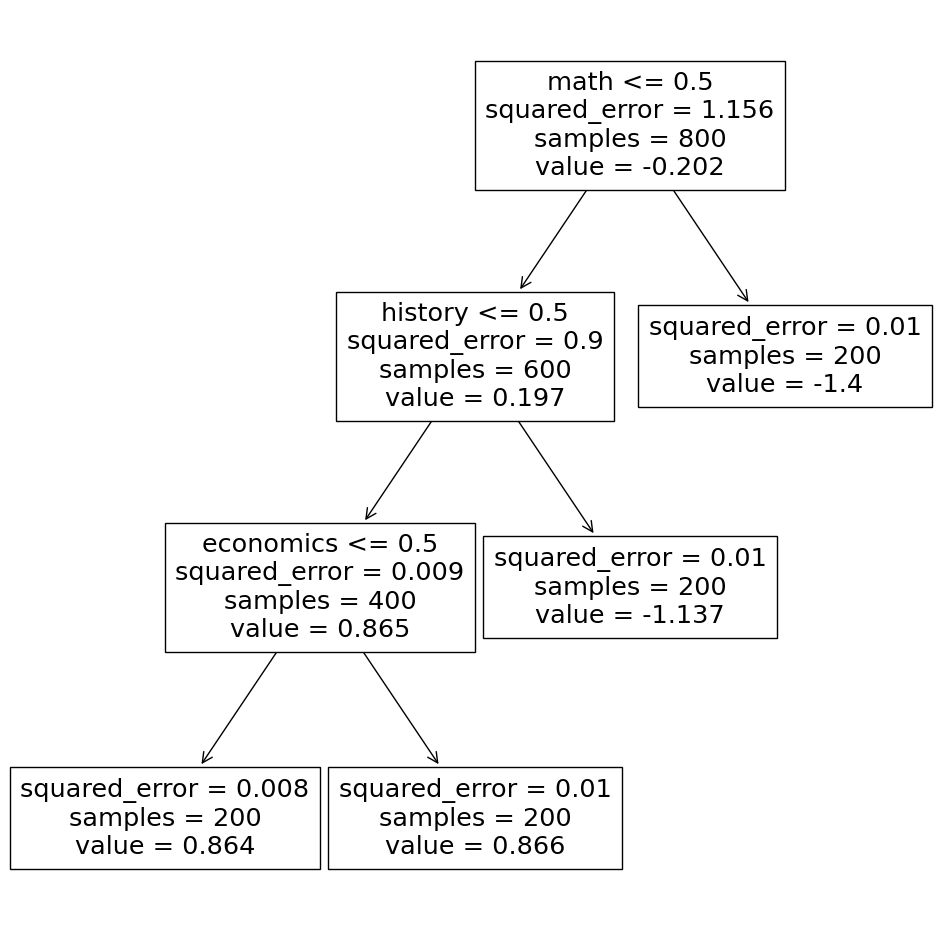

In [ ]:
# Initialize our tree so its max depth is 3
fitted_tree_cat = tree.DecisionTreeRegressor(max_depth=3)

# Fit tree on simulated data
fitted_tree_cat.fit(Xsim_cat,ysim_cat)

# Plot Tree
plt.figure(figsize=(12,12))
tree.plot_tree(fitted_tree_cat, feature_names = list(Xsim_cat));

## Random Forests
A **Random Forest** is the average of many randomized regression trees.

### What are Random Trees?
Trees are random in the sense that:
- We only let them see a random resample of the data
- We only let them split on a random subsample of the variables

Each of the trees gets its own random sample of the data and subsample of the variables it can split on.
### What is Resample of the data?
Instead of using the dataset we have, we take a sample of $n$ randomly chose observations from that dataset **without replacement** where $n$ is the size of the dataset. This is also called **bootstrapping** and means the same data point can appear numerous times within this resampled data.

### What does it mean to Average Trees?
To predict a given observation, a tree finds the terminal node that observation lies in (by looking at its $X$ values) and returns the average $y$ of **in-sample** observations that also lie in that terminal node.

To predict a given observation, a forest "sends" that observations to the $B$ trees that compose it and returns the average of those $B$ trees' predictions. Each of thboots

### Model Averaging
This is a specific example of what is known as **model averaging** where the output of many models (trees) are averaged to create an aggregate measure of


Let's train a random forest an observe its surface plot.

In [ ]:
# Import Model
from sklearn.ensemble import RandomForestRegressor

# Choose the number of trees and feed it our dataset
forest = RandomForestRegressor(n_estimators = 100).fit(Xsim,ysim)

fig=surface_scatter_plot(Xsim,ysim,lambda x: forest.predict([x]),
                         show_f0=False)
fig

FigureWidget({
    'data': [{'marker': {'opacity': 0.3, 'size': 2},
              'mode': 'markers',
              'type': 'scatter3d',
              'uid': 'fc489e76-a7bc-4bc9-8144-957c0959887f',
              'x': array([0.95307849, 0.79123071, 0.96973004, ..., 0.76970705, 0.17606146,
                          0.28852349]),
              'y': array([0.23796401, 0.3681229 , 0.58068303, ..., 0.0543484 , 0.12563072,
                          0.3031809 ]),
              'z': array([ 0.1098774 ,  0.29899488,  0.3845212 , ..., -0.04559703,  0.5825732 ,
                           0.8530211 ])},
             {'colorscale': [[0, '#165aa7'], [1, '#fec630']],
              'opacity': 1.0,
              'type': 'surface',
              'uid': '096f796e-08fb-45d1-8d74-41a2e2c8e805',
              'x': array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265, 0.10204082,
                          0.12244898, 0.14285714, 0.16326531, 0.18367347, 0.20408163, 0.2244898 ,
                     

In [ ]:
print(f"Tree of Depth 3 has in-sample MSE of {metrics.mean_squared_error(ysim, fitted_tree_3.predict(Xsim))}")
print(f"Tree of Depth 10 has in-sample MSE of {metrics.mean_squared_error(ysim, fitted_tree_10.predict(Xsim))}")
print(f"Random Forest has in-sample MSE of {metrics.mean_squared_error(ysim, forest.predict(Xsim))}")
print(f"Tree of Depth 3 has out-of-sample MSE of {metrics.mean_squared_error(ytest, fitted_tree_3.predict(Xtest))}")
print(f"Tree of Depth 10 has out-of-sample MSE of {metrics.mean_squared_error(ytest, fitted_tree_10.predict(Xtest))}")
print(f"Random Forest has out-of-sample MSE of {metrics.mean_squared_error(ytest, forest.predict(Xtest))}")


Tree of Depth 3 has in-sample MSE of 0.02008545555362475
Tree of Depth 10 has in-sample MSE of 0.002885979117755599
Random Forest has in-sample MSE of 0.0017542188556906896
Tree of Depth 3 has out-of-sample MSE of 0.02323621855190286
Tree of Depth 10 has out-of-sample MSE of 0.019160571487031108
Random Forest has out-of-sample MSE of 0.013515526855857378


## Trade-Offs
Random Forests frequently have better predictions than singular trees. Regularization comes from the randomness in the sample, the restriction of which features it can fit on, and the averaging of many trees. As a result, individual trees in a forest are frequently grown very deep.

While Random Forests tend to perform better than a simple tree, they
- take much longer to estimate as you have to grow many trees
- are not very interpretable and cannot be represented by a tree plot